In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

# '매출액',
# '매출총이익',
# '영업이익',
# '당기순이익',
# '자본',
# '자산',
# '영업활동으로인한현금흐름',
# '투자활동으로인한현금흐름'


plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
con = sqlite3.connect("../.out/changes.db")

df = pd.read_sql("select * from changes", con)
df = df.join((df["after_close"] / df["before_close"] - 1).to_frame("revenue"))
df

,code,before_close,before_cap,after_close,after_cap,before_date,after_date,매출총이익,영업이익,당기순이익,자산,자본,name,revenue
0,000020,1426,38668000000,1926.0,5.222700e+10,2001-04-30,2001-05-31,3.630961e+10,8.167152e+09,1.911550e+09,2.538914e+11,1.283201e+11,동화약품,0.350631
1,000040,38545,6013000000,41987.0,6.549000e+09,2001-04-30,2001-05-31,1.772354e+10,-1.394038e+10,-5.754296e+10,1.224912e+11,-6.835715e+10,KR모터스,0.089298
2,000050,1720,38036000000,1817.0,4.018100e+10,2001-04-30,2001-05-31,5.425668e+10,6.776929e+09,-4.210050e+08,6.484120e+11,3.746775e+11,경방,0.056395
3,000060,423,34737000000,753.0,6.183700e+10,2001-04-30,2001-05-31,NaN,-4.037319e+10,NaN,1.650858e+12,8.583474e+10,메리츠화재,0.780142
4,000070,11066,125975000000,14420.0,1.641570e+11,2001-04-30,2001-05-31,NaN,NaN,NaN,NaN,NaN,삼양홀딩스,0.303091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398206,950170,3500,122517000000,3120.0,1.092150e+11,2022-09-30,2022-10-31,-2.450100e+07,-3.807051e+10,-3.313825e+10,2.465567e+11,2.495650e+10,JTC,-0.108571
398207,950190,14250,193500000000,14100.0,1.914630e+11,2022-09-30,2022-10-31,6.398071e+10,2.903573e+10,2.445984e+10,1.298360e+11,1.047950e+11,미투젠,-0.010526
398208,950200,7240,138841000000,7100.0,1.361560e+11,2022-09-30,2022-10-31,7.863329e+09,-6.851537e+09,-6.829142e+09,5.276798e+10,3.466701e+10,소마젠,-0.019337
398209,950210,7900,474758000000,7590.0,4.561280e+11,2022-09-30,2022-10-31,NaN,-5.429810e+10,-2.282415e+11,4.998132e+11,4.299359e+11,프레스티지바이오파마,-0.039241


In [94]:
# 값 normalize
from util import normalize
from typing import *

df = df[df["after_date"].notnull()]
df = df.dropna()

col_map = {
    "매출총이익": "GP",
    "영업이익": "OP",
    "당기순이익": "NP",

    "자산": "A",
    "자본": "E",

    "영업활동으로인한현금흐름": "CFO",
    "투자활동으로인한현금흐름": "CFI",
    "재무활동으로인한현금흐름": "CFF"
}
profit_kinds = [
    "GP",
    # "OP",
    # "NP"
]
base_kinds = [
    "A",
    # "E"
]

df.columns = [col_map[col] if col in col_map else col for col in df.columns]

df2 = pd.DataFrame()


def join_factor(_df: pd.DataFrame, name: str, calc_factor: Callable[pd.DataFrame, pd.Series]):
    return _df.join(calc_factor(_df).to_frame(name))

for before_date, after_date in sorted(set([tuple(x) for x in df[["before_date", "after_date"]].values])):
    for pk in profit_kinds:
        for bk in base_kinds:
            sub_df = df[df["before_date"] == before_date]
            sub_df = join_factor(sub_df, f"{pk}/{bk}/P",
                                 lambda x: x[pk] / x[bk] / x["before_cap"])
            sub_df = join_factor(sub_df, f"Normalize({pk}/{bk}/P)",
                                 lambda x: normalize(x[pk] / x[bk] / x["before_cap"], based_zero=False))
            sub_df = join_factor(sub_df, f"Rank({pk}/{bk}/P)",
                                 lambda x: (x[pk] / x[bk] / x["before_cap"]).rank(ascending=False))
            df2 = pd.concat([df2, sub_df])


    # sub_df = sub_df.join(normalize(sub_df["GP"], based_zero=True).to_frame("GP"))
    # sub_df = sub_df.join(normalize(sub_df["영업이익"], based_zero=True).to_frame("OP"))
    # sub_df = sub_df.join(normalize(sub_df["당기순이익"], based_zero=True).to_frame("NP"))
    # sub_df = sub_df.join(normalize(sub_df["자산"], based_zero=True).to_frame("A"))
    # sub_df = sub_df.join(normalize(sub_df["자본"], based_zero=True).to_frame("E"))
    # sub_df = sub_df.join(normalize(sub_df["revenue"], based_zero=True).to_frame("R"))
    # df2 = pd.concat([df2, sub_df])

df2

,code,before_close,before_cap,after_close,after_cap,before_date,after_date,GP,OP,NP,A,E,name,revenue,GP/A/P,Normalize(GP/A/P),Rank(GP/A/P)
0,000020,1426,38668000000,1926.0,5.222700e+10,2001-04-30,2001-05-31,3.630961e+10,8.167152e+09,1.911550e+09,2.538914e+11,1.283201e+11,동화약품,0.350631,3.698468e-12,-0.280104,359.0
1,000040,38545,6013000000,41987.0,6.549000e+09,2001-04-30,2001-05-31,1.772354e+10,-1.394038e+10,-5.754296e+10,1.224912e+11,-6.835715e+10,KR모터스,0.089298,2.406325e-11,0.764742,41.0
2,000050,1720,38036000000,1817.0,4.018100e+10,2001-04-30,2001-05-31,5.425668e+10,6.776929e+09,-4.210050e+08,6.484120e+11,3.746775e+11,경방,0.056395,2.199922e-12,-0.356989,443.0
5,000100,3647,226934000000,4488.0,2.822990e+11,2001-04-30,2001-05-31,1.027477e+11,3.549174e+10,3.317437e+10,5.561362e+11,3.235817e+11,유한양행,0.230600,8.141253e-13,-0.428090,533.0
6,000120,6109,46605000000,7777.0,5.933000e+10,2001-04-30,2001-05-31,1.367289e+11,6.123050e+10,1.915162e+10,1.230582e+12,5.760898e+11,CJ대한통운,0.273040,2.384060e-12,-0.347542,432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398204,950130,11300,410359000000,13050.0,4.739100e+11,2022-09-30,2022-10-31,9.515554e+11,5.868799e+11,4.484146e+11,1.011116e+12,6.616357e+11,엑세스바이오,0.154867,2.293344e-12,0.266258,471.0
398205,950140,4335,86123000000,3905.0,7.758000e+10,2022-09-30,2022-10-31,2.839190e+10,1.139197e+10,1.229647e+10,1.399298e+11,9.015774e+10,잉글우드랩,-0.099193,2.355945e-12,0.292431,456.0
398206,950170,3500,122517000000,3120.0,1.092150e+11,2022-09-30,2022-10-31,-2.450100e+07,-3.807051e+10,-3.313825e+10,2.465567e+11,2.495650e+10,JTC,-0.108571,-8.110929e-16,-0.692904,1979.0
398207,950190,14250,193500000000,14100.0,1.914630e+11,2022-09-30,2022-10-31,6.398071e+10,2.903573e+10,2.445984e+10,1.298360e+11,1.047950e+11,미투젠,-0.010526,2.546672e-12,0.372171,405.0


0.006539433162159923


<BarContainer object of 2041 artists>

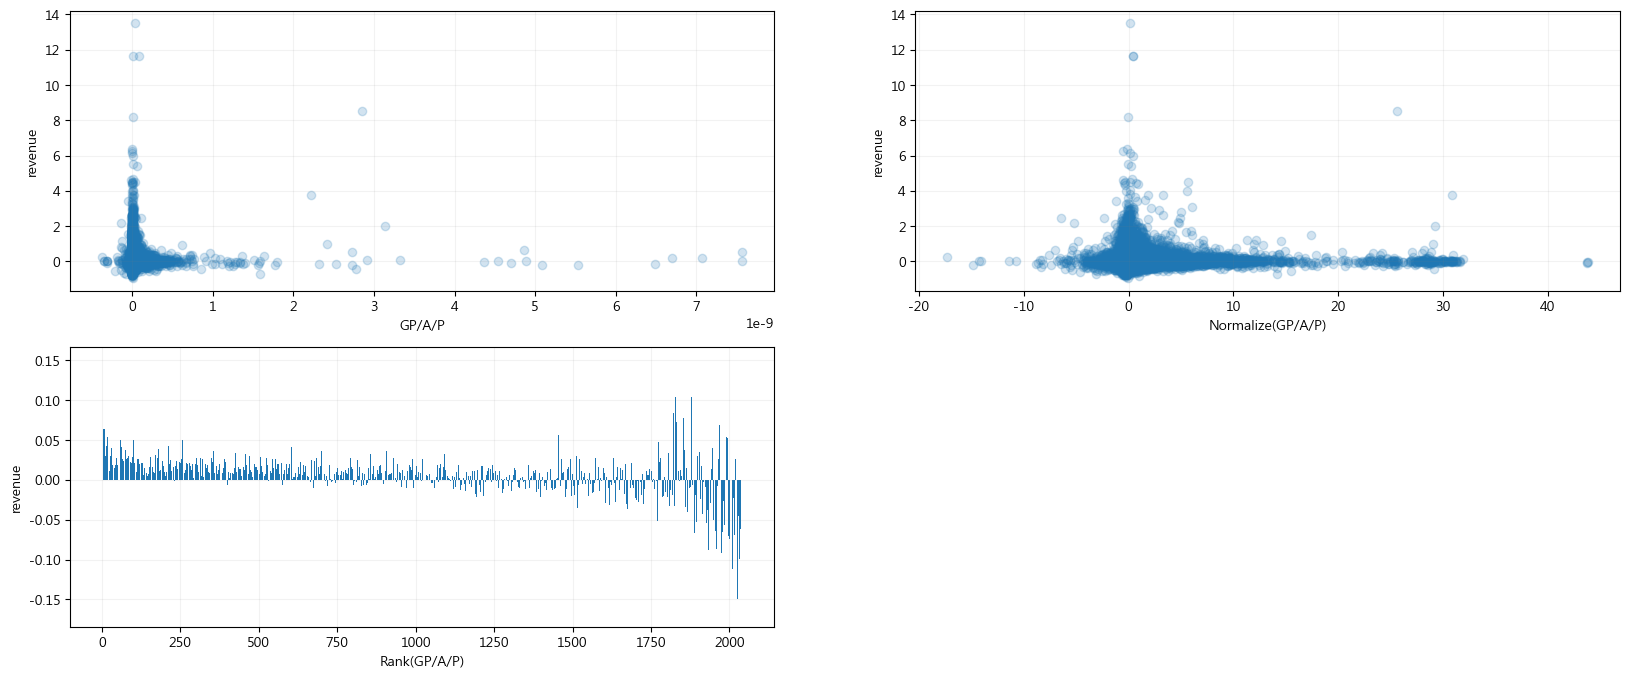

In [98]:
plt.figure(figsize=(20, 8))

x_label = "GP/A/P"
y_label = "revenue"
plt.subplot(2, 2, 1)
plt.grid(True)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.scatter(x=df2[x_label], y=df2[y_label], alpha=0.2)

x_label = "Normalize(GP/A/P)"
y_label = "revenue"
plt.subplot(2, 2, 2)
plt.grid(True)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.scatter(x=df2[x_label], y=df2[y_label], alpha=0.2)

x_label = "Rank(GP/A/P)"
y_label = "revenue"
plt.subplot(2, 2, 3)
plt.grid(True)
plt.xlabel(x_label)
plt.ylabel(y_label)
x = sorted(set(df2[x_label]))
y = [df2[df2[x_label] == rank][y_label].mean() for rank in x]
print(sum(y) / len(y))
plt.bar(x, y)